<a href="https://colab.research.google.com/github/rll/deepul/blob/master/homeworks/hw3/hw3_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an autoregressive model and run it on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [1]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF" -O hw3_data.zip && rm -rf /tmp/cookies.txt
!unzip -qq hw3_data.zip -d deepul/homeworks/hw3/data
!rm hw3_data.zip
!pip install ./deepul

Cloning into 'deepul'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 758 (delta 1), reused 0 (delta 0), pack-reused 749
Receiving objects: 100% (758/758), 117.08 MiB | 28.14 MiB/s, done.
Resolving deltas: 100% (346/346), done.
Checking out files: 100% (129/129), done.
--2020-12-09 22:15:37--  https://docs.google.com/uc?export=download&confirm=pEWG&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF
Resolving docs.google.com (docs.google.com)... 172.217.193.113, 172.217.193.100, 172.217.193.138, ...
Connecting to docs.google.com (docs.google.com)|172.217.193.113|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://doc-0c-b4-docs.googleusercontent.com/docs/securesc/mrch8frkbvulvvj4r2qbe8hp7gr1tgkl/hqai330sq26rbm7ke6l988jo9hv2rsnd/1607552100000/06419056966375271799/12374903431926908010Z/1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF?e=download [following]
--2020-12-09 22:15

In [2]:
from deepul.hw3_helper import *

In [3]:
from typing import NoReturn
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.distributions.normal import Normal
from torch.distributions.uniform import Uniform
import torch.utils.data as data

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

In [76]:
class Base(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError

    def loss(self, input: torch.Tensor) -> torch.Tensor:
        raise NotImplementedError
    
    def mode(self, mode_type: str) -> NoReturn:
        requires_grad = mode_type == 'train'
        for param in self.parameters():
            param.requires_grad = requires_grad


def step(model, dataloader, opt=None, mode_type='train'):
    if mode_type == 'train':
        model.train()
    else:
        model.eval()
    model.mode(mode_type) # вместо with torch.no_grad для eval.
    losses = [0.] * len(dataloader)
    for i, inp in enumerate(dataloader):
        loss = model.loss(inp.float().contiguous().to(device))
        losses[i] = [loss_comp.detach().cpu().item() for loss_comp in loss]
        if mode_type == 'train':
            opt.zero_grad()
            loss[0].backward()
            opt.step()
        else:
            losses[i] = [loss * inp.shape[0] for loss in losses[i]]
    return np.array(losses)


def train(model, opt, train_dataloader, test_dataloader, num_epochs):
    all_train_losses = []
    num_test_items = len(test_dataloader.dataset)
    all_test_losses = [(step(model, test_dataloader, None, 'test').sum(axis=0) 
                        / num_test_items)]
    print(f'Test loss: {all_test_losses[-1][0]}')
    for epoch in range(num_epochs):
        all_train_losses.extend(step(model, train_dataloader, opt, 'train'))
        all_test_losses.append(step(model, test_dataloader, None, 'test').sum(axis=0) 
                               / num_test_items)
        print(f'Test loss: {all_test_losses[-1][0]}')
    return all_train_losses, all_test_losses

# Question 1: VAEs on 2D Data [20pts]
In this question, you will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

In [ ]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-\log{p(x|z)}]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
class DummyNet(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim):
        super().__init__()
        self.layers = nn.Sequential(nn.Linear(in_dim, hidden_dim), nn.ReLU(), 
                                    nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
                                    nn.Linear(hidden_dim, out_dim))

    def forward(self, x):
        return self.layers(x)

In [ ]:
class GaussModel(nn.Module):
    def __init__(self, in_dim, hidden_dim, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim
        self.net = DummyNet(in_dim, hidden_dim, latent_dim * 2)
    
    def forward(self, x):
        gauss_params = self.net(x)
        mu, log_sigma = gauss_params[:, :self.latent_dim], gauss_params[:, self.latent_dim:]
        return mu, torch.exp(log_sigma)
    
    def generate(self, N, with_noise=True):
        z = torch.randn(N, self.latent_dim, device=device)
        #print(z.shape)
        #print(self.net)
        mu, sigma = self.forward(z)
        if with_noise:
            return torch.randn(mu.shape, device=device) * sigma + mu
        return mu

In [ ]:
class VAE(Base):
    def __init__(self, in_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder = GaussModel(in_dim, hidden_dim, latent_dim)
        self.decoder = GaussModel(latent_dim, hidden_dim, in_dim)
    
    def forward(self, x):
        mu_z, sigma_z = self.encoder(x)
        z = torch.randn(mu_z.shape, device=device) * sigma_z + mu_z
        mu_x, sigma_x = self.decoder(z)
        
        return z, mu_z, sigma_z, mu_x, sigma_x
    
    def loss(self, x):
        z, mu_z, sigma_z, mu_x, sigma_x= self.forward(x)
        gauss_dist = Normal(mu_x, sigma_x)
        rec_loss = -gauss_dist.log_prob(x).sum(axis=1).mean()
        kl_loss = -torch.log(sigma_z) + (sigma_z ** 2 + mu_z ** 2) * 1/2 - 1/2
        kl_loss = kl_loss.sum(axis=1).mean()
        return rec_loss + kl_loss, rec_loss, kl_loss
    
    def generate(self, N, with_noise):
        return self.decoder.generate(N, with_noise)

In [ ]:
def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
        if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
            used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
        and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
        and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """

    """ YOUR CODE HERE """ 
    train_dataloader = data.DataLoader(train_data, batch_size=256, shuffle=True)
    test_dataloader = data.DataLoader(test_data, batch_size=256)
    model = VAE(2, 128, 2).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    train_losses, test_losses = train(model, opt, train_dataloader, test_dataloader, 15)

    samples_with_noise = model.generate(1000, True)
    samples_without_noise = model.generate(1000, False)
    print(np.array(train_losses).shape)
    print(np.array(test_losses).shape)

    return np.array(train_losses), np.array(test_losses), samples_with_noise.cpu(), samples_without_noise.cpu()

### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

In [ ]:
q1_save_results('a', 1, q1)

In [ ]:
q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian [10pts]
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian. Execute the cell below to visualize the datasets (note that they may look the same, but notice the axes)

In [ ]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

### Results
Execute the cells below to visualize and save your results.

In [ ]:
q1_save_results('b', 1, q1)

In [ ]:
q1_save_results('b', 2, q1)

### Reflection
Compare the sampled xs with and without decoder noise in parts (a) and (b). For which datasets are the latents being used? Why is this happening (i.e. why are the latents being ignored in some cases)? **Write your answer (1-2 sentences) in the given latex template**

# Question 2: VAEs on Images [40pts]
In this question, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

In [ ]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE [20pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu() 
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten()
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$ (you can compute the extra constants if you want)
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

```
Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu() 
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten()
    linear(4 * 4 * 256, 2 * latent_dim)
```

In [ ]:
class Encoder(nn.Module):
    def __init__(self, latent_dim, input_shape):
        super().__init__()
        self.latent_dim = latent_dim
        self.layers = nn.Sequential(nn.Conv2d(input_shape[0], 32, 3, stride=1, padding=1), 
                                    nn.ReLU(), 
                                    nn.Conv2d(32, 64, 3, stride=2, padding=1), 
                                    nn.ReLU(), 
                                    nn.Conv2d(64, 128, 3, stride=2, padding=1), 
                                    nn.ReLU(), 
                                    nn.Conv2d(128, 256, 3, stride=2, padding=1), 
                                    nn.ReLU(), 
                                    nn.Flatten(), 
                                    nn.Linear(input_shape[1] * input_shape[2] * 4, 2 * latent_dim))
    
    def forward(self, x):
        gauss_params = self.layers(x)
        mu, log_sigma = gauss_params[:, :self.latent_dim], gauss_params[:, self.latent_dim:]
        return mu, torch.exp(log_sigma)

```
Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

In [ ]:
class Reshape(nn.Module):
    def __init__(self, new_shape):
        super().__init__()
        self.new_shape = new_shape
    
    def forward(self, x):
        return x.reshape(self.new_shape)

In [ ]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, output_shape):
        super().__init__()
        self.latent_dim = latent_dim
        self.layers = nn.Sequential(nn.Linear(latent_dim, 2 * output_shape[1] * output_shape[2]), 
                                    nn.ReLU(), 
                                    Reshape((-1, 128, output_shape[1] // 8, output_shape[2] // 8)), 
                                    nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1), 
                                    nn.ReLU(), 
                                    nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), 
                                    nn.ReLU(), 
                                    nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1), 
                                    nn.ReLU(), 
                                    nn.Conv2d(32, output_shape[0], 3, stride=1, padding=1)
                                    )
    
    def forward(self, x):
        mu = self.layers(x)
        return mu
    
    def generate(self, N):
        z = torch.randn(N, self.latent_dim, device=device)
        return self.forward(z)

In [ ]:
class VAE(Base):
    def __init__(self, latent_dim, input_shape):
        super().__init__()
        self.latent_dim = latent_dim
        self.encoder = Encoder(latent_dim, input_shape)
        self.decoder = Decoder(latent_dim, input_shape)

    def forward(self, x):
        mu_z, sigma_z = self.encoder(x)
        z = torch.randn(mu_z.shape, device=device) * sigma_z + mu_z

        mu_x = self.decoder(z)
        return z, mu_z, sigma_z, mu_x
    
    def loss(self, x):
        x = x / 255
        z, mu_z, sigma_z, mu_x = self.forward(x)
        gauss_dist = Normal(loc=mu_x, scale=1)
        rec_loss = ((x - mu_x) ** 2).reshape(-1, x.shape[0]).sum(axis=0).mean()
        kl_loss = -torch.log(sigma_z) + (sigma_z ** 2 + mu_z ** 2) * 1/2 - 1/2
        kl_loss = kl_loss.sum(axis=1).mean()
        return rec_loss + kl_loss, rec_loss, kl_loss
    
    def generate(self, N):
        x = torch.clamp(255 * self.decoder.generate(N), 0, 255)
        return x.permute((0, 2, 3, 1)).cpu().numpy()

    def reconstruct(self, x):
        x = torch.tensor(x / 255).to(device).float()
        mu_z, _ = self.encoder(x)
        mu_x = self.decoder(mu_z)
        x_rec = torch.clamp(mu_x, 0, 1)
        result = 255 * torch.cat([x, x_rec]).reshape((-1, 3, 32, 32))
        return result.permute((0, 2, 3, 1)).cpu().numpy()
  
    def interpolate(self, x):
        x = torch.tensor(x / 255).to(device).float()
        mu_z, _ = self.encoder(x)
        z_beg, z_end = mu_z[: x.shape[0] // 2], mu_z[x.shape[0] // 2:]
        result = [255 * torch.clamp(self.decoder(z_beg * a + z_end * (1 - a)), 0, 1) for a in np.linspace(0, 1, 10)]
        result = torch.cat(result, dim=1).reshape((-1, 3, 32, 32))
        return result.permute((0, 2, 3, 1)).cpu().numpy()

In [ ]:
def q2_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
        and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
        and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
        FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
        pairs of test images. The output should be those 100 images flattened into
        the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """
    train_data = train_data.transpose((0, 3, 1, 2))
    test_data = test_data.transpose((0, 3, 1, 2))
    train_dataloader = data.DataLoader(train_data, batch_size=128, shuffle=True)
    test_dataloader = data.DataLoader(test_data, batch_size=128)

    model = VAE(16, (3, 32, 32)).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)

    train_losses, test_losses = train(model, opt, train_dataloader, test_dataloader, 20)

    return (np.array(train_losses), np.array(test_losses), 
            model.generate(100), 
            model.reconstruct(test_data[:50]), 
            model.interpolate(test_data[:20]))

### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.

In [ ]:
q2_save_results('a', 1, q2_a)

In [ ]:
q2_save_results('a', 2, q2_a)

## Part (b) VAE with AF Prior [20pts]
In this part, implement a VAE with an Autoregressive Flow prior ([VLAE](https://arxiv.org/abs/1611.02731)) with the following characteristics:

*   16-dim latent variables $z$ with a MADE prior, with $\epsilon \sim N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can use the same encoder / decoder architectures and training hyperparameters as part (a). For your MADE prior, it would suffice to use two hidden layers of size $512$. More explicitly, your MADE AF (mapping from $z\rightarrow \epsilon$) should output location $\mu_\psi(z)$ and scale parameters $\sigma_\psi(z)$ and do the following transformation on $z$:
$$\epsilon = z \odot \sigma_\psi(z) + \mu_\psi(z)$$

where the $i$th element of $\sigma_\psi(z)$ is computed from $z_{<i}$ (same for $\mu_\psi(z)$) and optimize the objective

$$-E_{z\sim q(z|x)}[\log{p(x|z)}] + E_{z\sim q(z|x)}[\log{q(z|x)} - \log{p(z)}]$$
where $$\log{p(z)} = \log{p(\epsilon)} + \log{\det\left|\frac{d\epsilon}{dz}\right|}$$





**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def q2_b(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """

### Results
Once you've finished `q2_b`, execute the cells below to visualize and save your results.

In [ ]:
q2_save_results('b', 1, q2_b)

In [ ]:
q2_save_results('b', 2, q2_b)

# Question 3: VQ-VAE [40pts]
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder): 
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, you will also need to train a PixelCNN prior on the categorical latents in order to sample. For your architecture, you may find the following useful:
*   Since the input is a 2D grid of discrete values, you should have an input (learned) embedding layer to map the discrete values to embeddings of length $64$
*   Use a single Type A masked convolutions followed by 10-15 residual blocks (same structure as HW 1), and $2$ $1\times 1$ convolutions of $512$ and $K$ channels respectively.
*   You may find normalization methods (e.g. BatchNorm, LayerNorm) to be useful
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and PixelCNN prior**. Code is provided that automatically plots the training curves. 
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and PixelCNN prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)


residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)
```

In [6]:
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.model = nn.Sequential(nn.BatchNorm2d(dim), 
                                   nn.ReLU(), 
                                   nn.Conv2d(dim, dim, 3, stride=1, padding=1), 
                                   nn.BatchNorm2d(dim), 
                                   nn.ReLU(), 
                                   nn.Conv2d(dim, dim, 1, stride=1, padding=0))
    def forward(self, x):
        return self.model(x) + x

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)
```

In [7]:
class Encoder(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.model = nn.Sequential(nn.Conv2d(3, dim, 4, stride=2, padding=1), 
                                   nn.BatchNorm2d(dim), 
                                   nn.ReLU(), 
                                   nn.Conv2d(dim, dim, 4, stride=2, padding=1), 
                                   ResidualBlock(dim), 
                                   ResidualBlock(dim))
    def forward(self, x):
        return self.model(x)

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)
 
Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

In [16]:
class Decoder(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.model = nn.Sequential(ResidualBlock(dim), 
                                   ResidualBlock(dim), 
                                   nn.BatchNorm2d(dim), 
                                   nn.ReLU(), 
                                   nn.ConvTranspose2d(dim, dim, 4, 
                                                      stride=2, padding=1), 
                                   nn.BatchNorm2d(dim), 
                                   nn.ReLU(), 
                                   nn.ConvTranspose2d(dim, 3, 4, 
                                                      stride=2, padding=1))
    def forward(self, x):
        return self.model(x)

In [9]:
class LatentNeighbour(nn.Module):
    def __init__(self, dim, n_latents):
        super().__init__()
        self.dim = dim
        self.n_latents = n_latents
        self.latents = nn.Embedding(num_embeddings=n_latents, 
                                    embedding_dim=dim)
        nn.init.uniform_(self.latents.weight, -1 / n_latents, 1 / n_latents)
        
    def forward(self, x):
        dist = torch.cdist(x.permute(0, 2, 3, 1).reshape((-1, self.dim)), 
                           self.latents.weight)
        neerest_ind = torch.min(dist, dim=1)[1]
        neerest_ind = neerest_ind.reshape((x.shape[0], x.shape[2], x.shape[3]))
        neerest_latent = self.latents(neerest_ind).permute(0, 3, 1, 2)
        return neerest_ind, neerest_latent

In [58]:
class VQ_VAE(Base):
    def __init__(self, dim, n_latents):
        super().__init__()
        self.dim = dim
        self.n_latents = n_latents
        self.encoder = Encoder(dim)
        self.decoder = Decoder(dim)
        self.latent = LatentNeighbour(dim, n_latents)
    
    def forward(self, x):
        z = self.encoder(x)
        neerest_ind, neerest_latent = self.latent(z)
        neerest_latent_grad = (z + (neerest_latent - z).detach())
        return z, neerest_ind, neerest_latent, neerest_latent_grad
    
    def loss(self, x):
        z, neerest_ind, neerest_latent, neerest_latent_grad = self.forward(x)
        encoder_part = F.mse_loss(z, neerest_latent.detach())
        latent_part = F.mse_loss(neerest_latent, z.detach())
        reconstruct = self.decoder(neerest_latent_grad)
        decoder_part = F.mse_loss(reconstruct, x)
        full_loss = encoder_part + latent_part + decoder_part
        return full_loss, encoder_part, latent_part, decoder_part
    
    def encode(self, loader):
        nearest = []
        for x in loader:
            x = x.to(device).float()
            z = self.encoder(x)
            nearest_idx, nearest_latent = self.latent(z)
            nearest.append(nearest_idx)       
        return torch.cat(nearest)
    
    def decode(self, idxs):
        latents = self.latent.latents(idxs).permute(0, 3, 1, 2)
        decoded = self.decoder(latents)
        return decoded.permute(0, 2, 3, 1)
    
    def reconstruct(self, x):
        z = self.encode([x])
        reconstruct = self.decode(z)
        res = torch.stack([x.permute(0, 2, 3, 1), reconstruct], axis=1)
        res = res.reshape(-1, 32, 32, 3)
        return res 


In [11]:
def create_mask(kernel_size, weight_size, mode='A'):
    mask = np.zeros(weight_size)
    kernel_size = kernel_size[0]
    if mode == 'A':     
        mask[:, :, kernel_size // 2, :kernel_size // 2] = 1
    elif mode == 'B':
        mask[:, :, kernel_size // 2, :kernel_size // 2 + 1] = 1
    else:
        raise ValueError('Unknown mode')
    mask[:, :, :kernel_size // 2] = 1
    return mask

class MaskedConv(nn.Conv2d):
    def __init__(self, mode, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.mode = mode
        mask = create_mask(self.kernel_size, self.weight.shape, mode)
        self.set_mask(mask)
    
    def set_mask(self, mask: torch.Tensor) -> NoReturn:
        self.mask = torch.from_numpy(mask).clone().to(device)

    def forward(self, x):
        self.weight.data *= self.mask
        return super(MaskedConv, self).forward(x)

In [12]:
class LayerNorm(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.layer = nn.LayerNorm(dim)
    
    def forward(self, x):
        return self.layer(x.permute(0, 2, 3, 1)).permute(0, 3, 1, 2)

class ResidualBlockPixCNN(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.model = nn.Sequential(nn.ReLU(), 
                                   MaskedConv('B', dim, dim // 2, 1), 
                                   LayerNorm(dim // 2), 
                                   nn.ReLU(),
                                   MaskedConv('B', dim // 2, dim //2 , 3, 
                                              stride=1, padding=1), 
                                   LayerNorm(dim // 2),
                                   nn.ReLU(), 
                                   MaskedConv('B', dim // 2, dim, 1), 
                                   LayerNorm(dim))
    def forward(self, x):
        return self.model(x)

In [40]:
class PixelCNN(Base):
    def __init__(self, input_size, dim, n_latents):
        super().__init__()
        self.input_size = input_size
        self.dim = dim
        self.n_latents = n_latents
        self.embedding = nn.Embedding(num_embeddings=n_latents, 
                                      embedding_dim=dim)
        self.model = nn.Sequential(MaskedConv('A', dim, dim, 7, 1, 3), 
                                   LayerNorm(dim), 
                                   nn.ReLU(), 
                                   *[ResidualBlockPixCNN(dim) for _ in range(10)], 
                                   LayerNorm(dim),
                                   nn.ReLU(), 
                                   MaskedConv('B', dim, 2 * dim, 1), 
                                   LayerNorm(2 * dim), 
                                   nn.ReLU(),  
                                   MaskedConv('B', 2 * dim, n_latents, 1), 
                                   )
    def forward(self, x):
        x = self.embedding(x.long()).permute(0, 3, 1, 2)
        return self.model(x)
    
    def loss(self, x):
        x = x.long()
        return [F.cross_entropy(self.forward(x), x)]
    
    def sample(self, n_samples):
        samples = torch.zeros(n_samples, *self.input_size).to(device).long()
        #samples = torch.zeros(n_samples, *self.input_size).long()
        for i in range(self.input_size[0]):
            for j in range(self.input_size[1]):
                self.forward(samples)[:, :, i, j]
                p = F.softmax(self.forward(samples)[:, :, i, j], dim=1)
                samples[:, i, j] = torch.multinomial(p, 1)[...,0]
        return samples 

In [80]:
def q3(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
                used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
        FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """
    train_data = train_data.transpose((0, 3, 1, 2)) / 255
    test_data = test_data.transpose((0, 3, 1, 2)) / 255
    train_dataloader = data.DataLoader(train_data, batch_size=256, shuffle=True)
    test_dataloader = data.DataLoader(test_data, batch_size=256)

    print("Train VQ-VAE")
    vqvae = VQ_VAE(256, 128).to(device)
    opt = torch.optim.Adam(vqvae.parameters(), lr=1e-3)
    vqvae_train_losses, vqvae_test_losses = train(vqvae, opt, train_dataloader, 
                                                  test_dataloader, 20)
 

    print("\nTrain PixelCNN")
    train_encoded_dataloader = data.DataLoader(vqvae.encode(train_dataloader), 
                                               batch_size=256, shuffle=True)
    test_encoded_dataloader = data.DataLoader(vqvae.encode(test_dataloader), 
                                              batch_size=256)

    pcnn = PixelCNN((8, 8), 256, 128).to(device)
    opt = torch.optim.Adam(pcnn.parameters(), lr=1e-4)
    pcnn_train_losses, pcnn_test_losses = train(pcnn, opt, train_encoded_dataloader, 
                                                test_encoded_dataloader, 20)
    
    samples = pcnn.sample(100)
    samples = vqvae.decode(samples) * 255

    reconstruct = vqvae.reconstruct(torch.Tensor(test_data[:50]).to(device)) * 255
    return (np.array(vqvae_train_losses)[:, 0], np.array(vqvae_test_losses)[:, 0], 
            np.array(pcnn_train_losses)[:, 0], np.array(pcnn_test_losses)[:, 0], 
            np.array(samples.cpu()), np.array(reconstruct.cpu()))
    

## Results
Once you've finished `q3`, execute the cells below to visualize and save your results.

Train VQ-VAE
Test loss: 0.2963615773200989
Test loss: 7.047155289459228
Test loss: 2.683281716156006
Test loss: 1.1726370771408081
Test loss: 0.6538573441505432
Test loss: 0.44196888127326966
Test loss: 0.3243260736465454
Test loss: 0.2670579966068268
Test loss: 0.20928123195171355
Test loss: 0.17558756036758422
Test loss: 0.14458760521411895
Test loss: 0.126946122610569
Test loss: 0.10491154987812042
Test loss: 0.09783730837106705
Test loss: 0.08375895171165466
Test loss: 0.07221877989768982
Test loss: 0.06950500211715699
Test loss: 0.06495983002185822
Test loss: 0.05601668598651886
Test loss: 0.05161530659198761
Test loss: 0.050162771379947665

Train PixelCNN
Test loss: 4.996732073974609
Test loss: 2.7170987174987795
Test loss: 2.1165231212615967
Test loss: 1.8524986284255982
Test loss: 1.6660828001022339
Test loss: 1.6116758548736572
Test loss: 1.5743003297805787
Test loss: 1.498739111328125
Test loss: 1.4221139083862304
Test loss: 1.4405426239013672
Test loss: 1.3688473987579346
Te

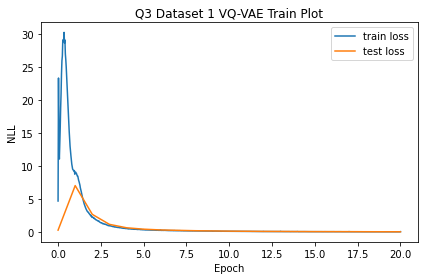

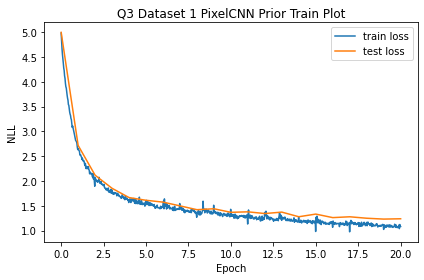

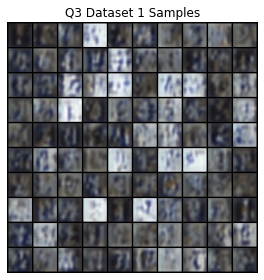

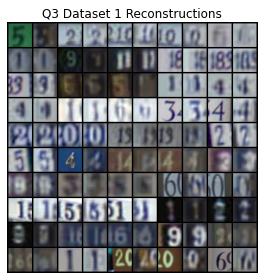

In [81]:
torch.manual_seed(42)
np.random.seed(42)
q3_save_results(1, q3)

Train VQ-VAE
Test loss: 0.3133676162719727
Test loss: 0.39856505298614503
Test loss: 0.1332477698802948
Test loss: 0.08406737570762635
Test loss: 0.0614108259677887
Test loss: 0.04874101859331131
Test loss: 0.04171767260432244
Test loss: 0.03629704061746597
Test loss: 0.03160104793310165
Test loss: 0.02857409757375717
Test loss: 0.02692450437247753
Test loss: 0.024053929102420806
Test loss: 0.022911248490214347
Test loss: 0.021483576267957688
Test loss: 0.02072908287644386
Test loss: 0.020304952198266984
Test loss: 0.018732634061574938
Test loss: 0.01808294985294342
Test loss: 0.017049898818135262
Test loss: 0.01709151700437069
Test loss: 0.01596238451898098

Train PixelCNN
Test loss: 4.963767594146728
Test loss: 3.8662777172088623
Test loss: 3.830750100708008
Test loss: 3.3650590873718262
Test loss: 3.304055696487427
Test loss: 3.1501406021118163
Test loss: 3.1414246311187743
Test loss: 3.1015331214904784
Test loss: 3.081043202972412
Test loss: 3.076281369781494
Test loss: 3.065063982

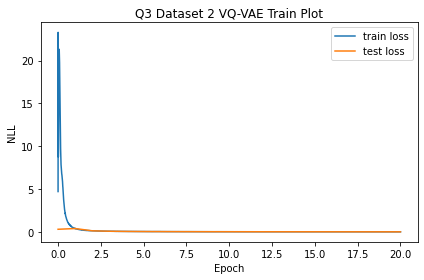

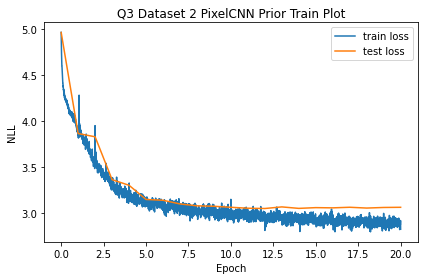

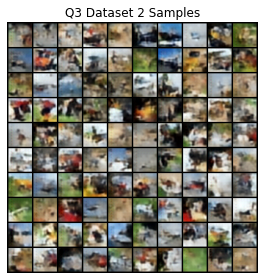

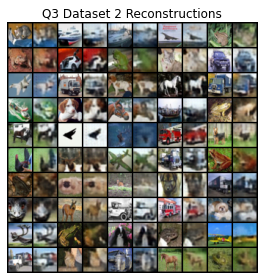

In [82]:
q3_save_results(2, q3)

# Question 4 Bonus [15pts]

## Part (a) Improving VQ-VAE Results [10pts]
Improve upon your results in Q3, one option being trying to implement or train a stronger autoregressive model such as a Gated PixelCNN.

### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def q4_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """

### Results
Once you've finished `q4_a`, execute the cells below to visualize and save your results.

In [ ]:
q4_a_save_results(2, q4_a)

## Part (b) PixelVAE [5pts]
Implement and train a VAE with a PixelCNN decoder, and get it to produce good samples but not ignore latents. It may help to reference the latent variable model slides on techniques to prevent posterior collapse.

### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def q4_b(train_data, test_data):
    """
    train_data: An (n_train, 28, 28, 1) uint8 numpy array of MNIST binary images
    test_data: An (n_test, 28, 28, 1) uint8 numpy array of MNIST binary images

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 28, 28, 1) numpy array of 100 samples with values in {0, 1}
    - a (100, 28, 28, 1) numpy array of 50 real-image / reconstruction pairs with values in {0, 1}
    """

    """ YOUR CODE HERE """ 

### Results
Once you've finished `q4_b`, execute the cells below to visualize and save your results

In [ ]:
q4_b_save_results(q4_b)

# File Saving Utility


In [ ]:
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)